# winddy

**分析正常模型和经过对抗训练后的模型在某一种类别上的识别率和信息熵的差别**

In [59]:
import torch 
import numpy as np
import os
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
from LeNet import LeNet
from torch.autograd import Variable
import pylab

In [60]:
NORMALIZE = True
DEVICE = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')

In [61]:
if NORMALIZE:
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
else:
    trans = transforms.Compose([
        transforms.ToTensor(),
    ])

In [62]:
data_home = '/data/winddy/'

train_set = torchvision.datasets.MNIST(root=os.path.join(data_home, 'dataset/MNIST'), train=True, download=True, transform=trans)
test_set = torchvision.datasets.MNIST(root=os.path.join(data_home, 'dataset/MNIST'), train=False, download=True, transform=trans)

In [63]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, num_workers=2)

In [64]:
# 可视化数据集
def imshow(img):
    if NORMALIZE:
        img = img * 0.3081 + 0.1307
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()
    
class FGSM:
    def __init__(self, model, criterion, epsilon, device):
        self.model = model
        self.criterion = criterion
        self.epsilon = epsilon
        self.device = device
        assert isinstance(model, torch.nn.Module), "Input parameter model is not nn.Module. Check the model"
        assert isinstance(criterion, torch.nn.Module), "Input parameter criterion is no Loss. Check the criterion"
        assert (0 <= epsilon <= 1), "episilon must be 0 <= epsilon <= 1"
        self.model.eval()


    def __call__(self, input, labels):
        # For calculating gradient
        input_for_gradient = Variable(input, requires_grad=True).to(self.device)
        out = self.model(input_for_gradient)
        loss = self.criterion(out, Variable(labels))

        # Calculate gradient
        loss.backward()

        # Calculate sign of gradient
        signs = torch.sign(input_for_gradient.grad.data)

        # Add
        input_for_gradient.data = input_for_gradient.data + (self.epsilon * signs)

        return input_for_gradient, signs
    
    
def MyPlot(images, titles):
    nrows = 2
    ncols = 5
    plt.rcParams['figure.figsize'] = (12.0, 12.0)
    plt.figure(figsize=(4 * ncols, 4 * nrows))
    
    count = 1
    
    for i,img in enumerate(images):
        plt.subplot(nrows, ncols, count)
        plt.plot(img)
        plt.title(titles[i])
        plt.axis('off')
        count += 1
    plt.show()

# 正常模型 - 特定类别的输出的信息熵

In [65]:
key_info = {'1':'model - clean', '2':'model - advExam', '3': 'modelAdv - clean', '4':'modelAdv - advExam'}
result_info = {}

## 正常模型 - 干净样本

In [66]:
# 读取模型
if NORMALIZE:
    model_path = './model/LeNet_MNIST.pt'
else:
    model_path = './model/LeNet_MNIST_unNormalize.pt'

model = LeNet()
model.load_state_dict(torch.load(model_path))
model = model.to(DEVICE)

In [67]:

model.eval()

images_targets = {}

for special_index in range(10):
    count = 0
    correct = 0
    info_arr = torch.tensor([])
    info_arr = info_arr.to(DEVICE)
    with torch.no_grad():
        for data, target in test_loader:
            data = data[target==special_index]
            target = target[target==special_index]
            if len(data) == 0:
                continue

            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            
            # 计算熵
            tmp_output = torch.softmax(output, dim=1)
            info_entropy = -tmp_output * torch.log2(tmp_output)
            info_entropy = info_entropy.sum(dim=1)
            info_arr = torch.cat((info_arr, info_entropy))
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            count += len(data)
            print('\r {}'.format(count), end='')
    images_targets[special_index] = [count, correct/count, info_arr.cpu().numpy()]
    print('\n {} correct: {}'.format(special_index,correct/count))

 980
 0 correct: 0.9938775510204082
 1135
 1 correct: 0.9964757709251101
 1032
 2 correct: 0.9864341085271318
 1010
 3 correct: 0.9930693069306931
 982
 4 correct: 0.9938900203665988
 892
 5 correct: 0.9798206278026906
 958
 6 correct: 0.9916492693110647
 1028
 7 correct: 0.9902723735408561
 974
 8 correct: 0.9835728952772074
 1009
 9 correct: 0.9692765113974232


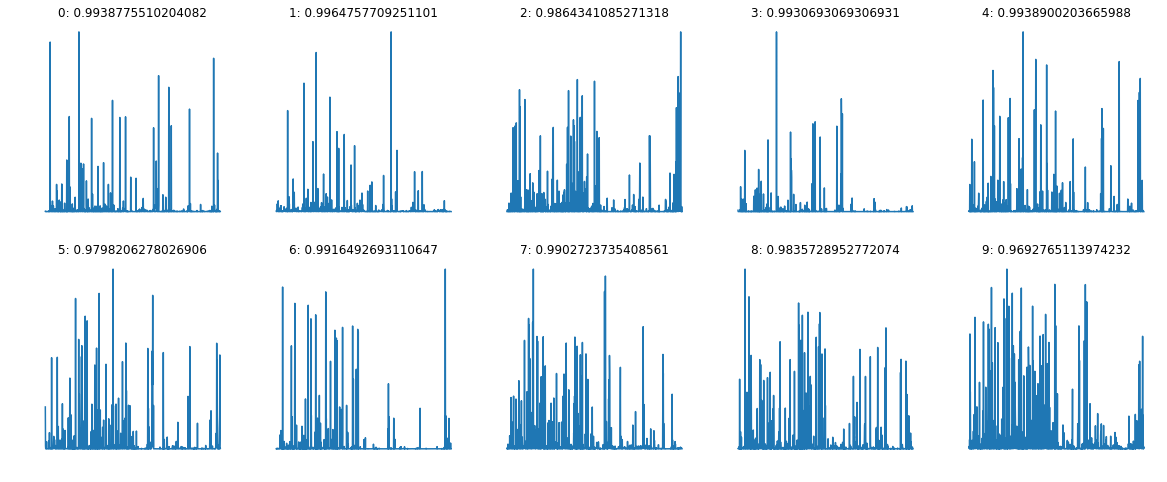

In [68]:
images = []
titles = []
for key_img in images_targets.keys():
    titles.append('' + str(key_img) + ': ' + str(images_targets[key_img][1]))
    images.append(images_targets[key_img][2])
MyPlot(images, titles)

result_info['1'] = images_targets

## 正常模型 - 对抗样本

In [69]:
epsilon = 0.3
criterion = nn.CrossEntropyLoss()
fgsm = FGSM(model, criterion, epsilon, DEVICE)

In [70]:

model.eval()

images_targets = {}
for special_index in range(10):
    count = 0
    correct = 0
    info_arr = torch.tensor([])
    info_arr = info_arr.to(DEVICE)
    for data, target in test_loader:
        data = data[target==special_index]
        target = target[target==special_index]
        if len(data) == 0:
            continue

        data, target = data.to(DEVICE), target.to(DEVICE)
        data, sign = fgsm(data, target)
        output = model(data)

        # 计算熵
        tmp_output = torch.softmax(output, dim=1)
        info_entropy = -tmp_output * torch.log2(tmp_output)
        info_entropy = info_entropy.sum(dim=1)
        info_arr = torch.cat((info_arr, info_entropy))

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        count += len(data)
        print('\r {}'.format(count), end='')
    images_targets[special_index] = [count, correct/count, info_arr.detach().cpu().numpy()]
    print('\n {} correct: {}'.format(special_index,correct/count))

 980
 0 correct: 0.8724489795918368
 1135
 1 correct: 0.9268722466960353
 1032
 2 correct: 0.6957364341085271
 1010
 3 correct: 0.8653465346534653
 982
 4 correct: 0.769857433808554
 892
 5 correct: 0.7533632286995515
 958
 6 correct: 0.8830897703549061
 1028
 7 correct: 0.7762645914396887
 974
 8 correct: 0.5010266940451745
 1009
 9 correct: 0.398414271555996


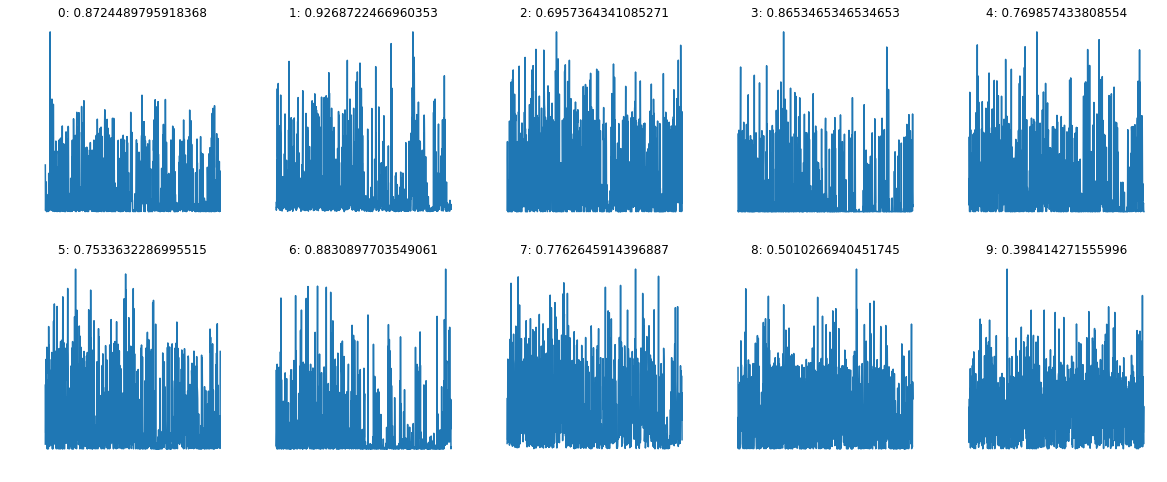

In [71]:
images = []
titles = []
for key_img in images_targets.keys():
    titles.append('' + str(key_img) + ': ' + str(images_targets[key_img][1]))
    images.append(images_targets[key_img][2])
MyPlot(images, titles)

result_info['2'] = images_targets

# 对抗训练的模型

## 对抗模型 - 干净样本

In [72]:
# 读取模型
if NORMALIZE:
    model_path = './model/LeNet_MNIST_adv.pt'
else:
    model_path = './model/LeNet_MNIST_unNormalize_adv.pt'

model_adv = LeNet()
model_adv.load_state_dict(torch.load(model_path))
print('read model: {}'.format(model_path))
model_adv = model_adv.to(DEVICE)

read model: ./model/LeNet_MNIST_adv.pt


In [73]:

model_adv.eval()

images_targets = {}
for special_index in range(10):
    count = 0
    correct = 0
    info_arr = torch.tensor([])
    info_arr = info_arr.to(DEVICE)
    for data, target in test_loader:
        data = data[target==special_index]
        target = target[target==special_index]
        if len(data) == 0:
            continue

        data, target = data.to(DEVICE), target.to(DEVICE)
        output = model_adv(data)

        # 计算熵
        tmp_output = torch.softmax(output, dim=1)
        info_entropy = -tmp_output * torch.log2(tmp_output)
        info_entropy = info_entropy.sum(dim=1)
        info_arr = torch.cat((info_arr, info_entropy))

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        count += len(data)
        print('\r {}'.format(count), end='')
    images_targets[special_index] = [count, correct/count, info_arr.detach().cpu().numpy()]
    print('\n {} correct: {}'.format(special_index,correct/count))

 980
 0 correct: 0.9959183673469387
 1135
 1 correct: 0.9955947136563876
 1032
 2 correct: 0.9903100775193798
 1010
 3 correct: 0.9762376237623762
 982
 4 correct: 0.9826883910386965
 892
 5 correct: 0.9831838565022422
 958
 6 correct: 0.9916492693110647
 1028
 7 correct: 0.9659533073929961
 974
 8 correct: 0.9845995893223819
 1009
 9 correct: 0.9762140733399405


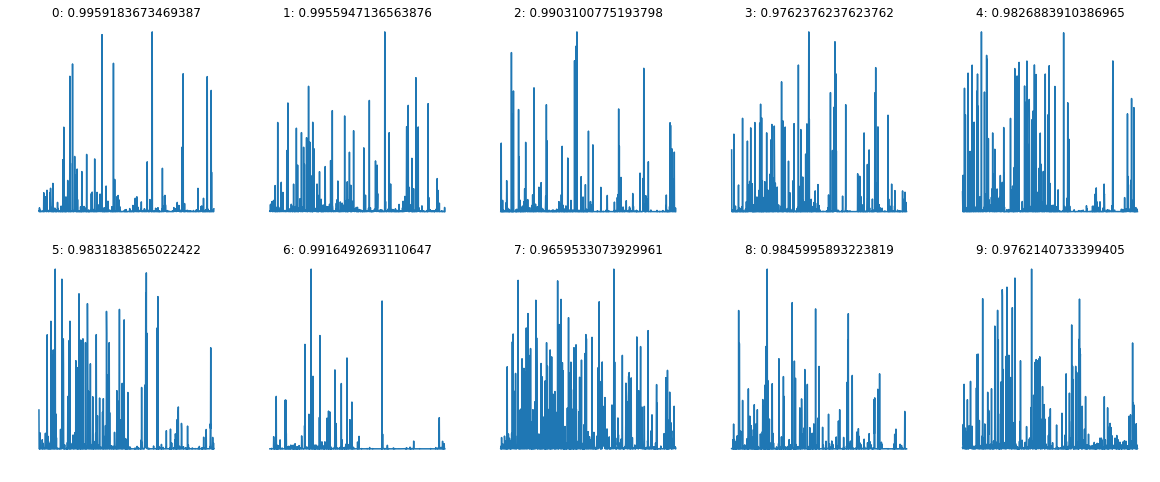

In [74]:
images = []
titles = []
for key_img in images_targets.keys():
    titles.append('' + str(key_img) + ': ' + str(images_targets[key_img][1]))
    images.append(images_targets[key_img][2])
MyPlot(images, titles)

result_info['3'] = images_targets

 ## 对抗模型 - 对抗样本

In [75]:
# 读取模型
if NORMALIZE:
    model_path = './model/LeNet_MNIST_adv.pt'
else:
    model_path = './model/LeNet_MNIST_unNormalize_adv.pt'

model_adv = LeNet()
model_adv.load_state_dict(torch.load(model_path))
print('read model: {}'.format(model_path))
model_adv = model_adv.to(DEVICE)

read model: ./model/LeNet_MNIST_adv.pt


In [76]:

model_adv.eval()

images_targets = {}
for special_index in range(10):
    count = 0
    correct = 0
    info_arr = torch.tensor([])
    info_arr = info_arr.to(DEVICE)
    for data, target in test_loader:
        data = data[target==special_index]
        target = target[target==special_index]
        if len(data) == 0:
            continue

        data, target = data.to(DEVICE), target.to(DEVICE)
        data, sign = fgsm(data, target)
        output = model_adv(data)

        # 计算熵
        tmp_output = torch.softmax(output, dim=1)
        info_entropy = -tmp_output * torch.log2(tmp_output)
        info_entropy = info_entropy.sum(dim=1)
        info_arr = torch.cat((info_arr, info_entropy))

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        count += len(data)
        print('\r {}'.format(count), end='')
    images_targets[special_index] = [count, correct/count, info_arr.detach().cpu().numpy()]
    print('\n {} correct: {}'.format(special_index,correct/count))

 980
 0 correct: 0.9928571428571429
 1135
 1 correct: 0.9938325991189427
 1032
 2 correct: 0.9893410852713178
 1010
 3 correct: 0.9782178217821782
 982
 4 correct: 0.9928716904276986
 892
 5 correct: 0.9820627802690582
 958
 6 correct: 0.9906054279749478
 1028
 7 correct: 0.9776264591439688
 974
 8 correct: 0.9763860369609856
 1009
 9 correct: 0.9821605550049554


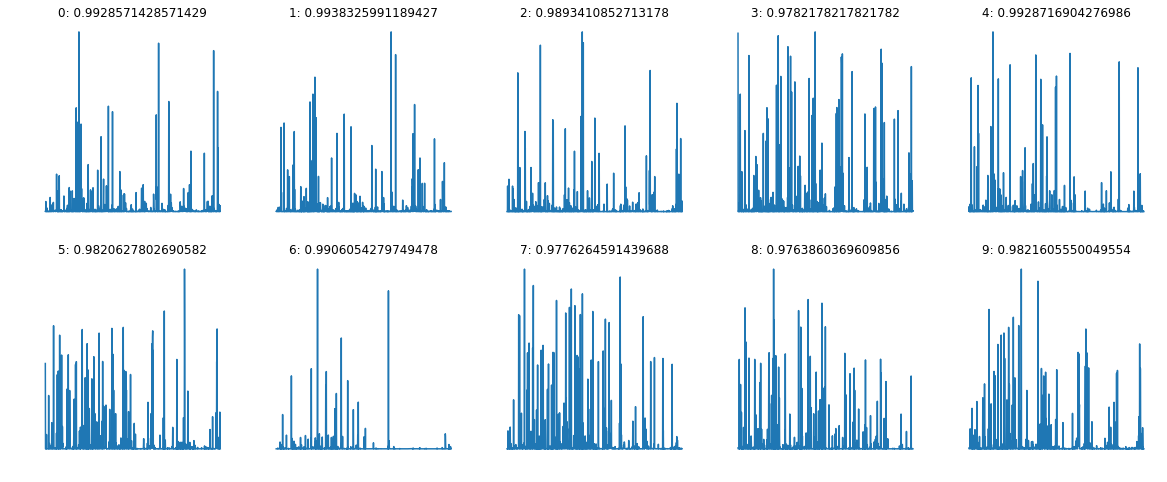

In [77]:
images = []
titles = []
for key_img in images_targets.keys():
    titles.append('' + str(key_img) + ': ' + str(images_targets[key_img][1]))
    images.append(images_targets[key_img][2])
MyPlot(images, titles)

result_info['4'] = images_targets

# 结果

## 分析

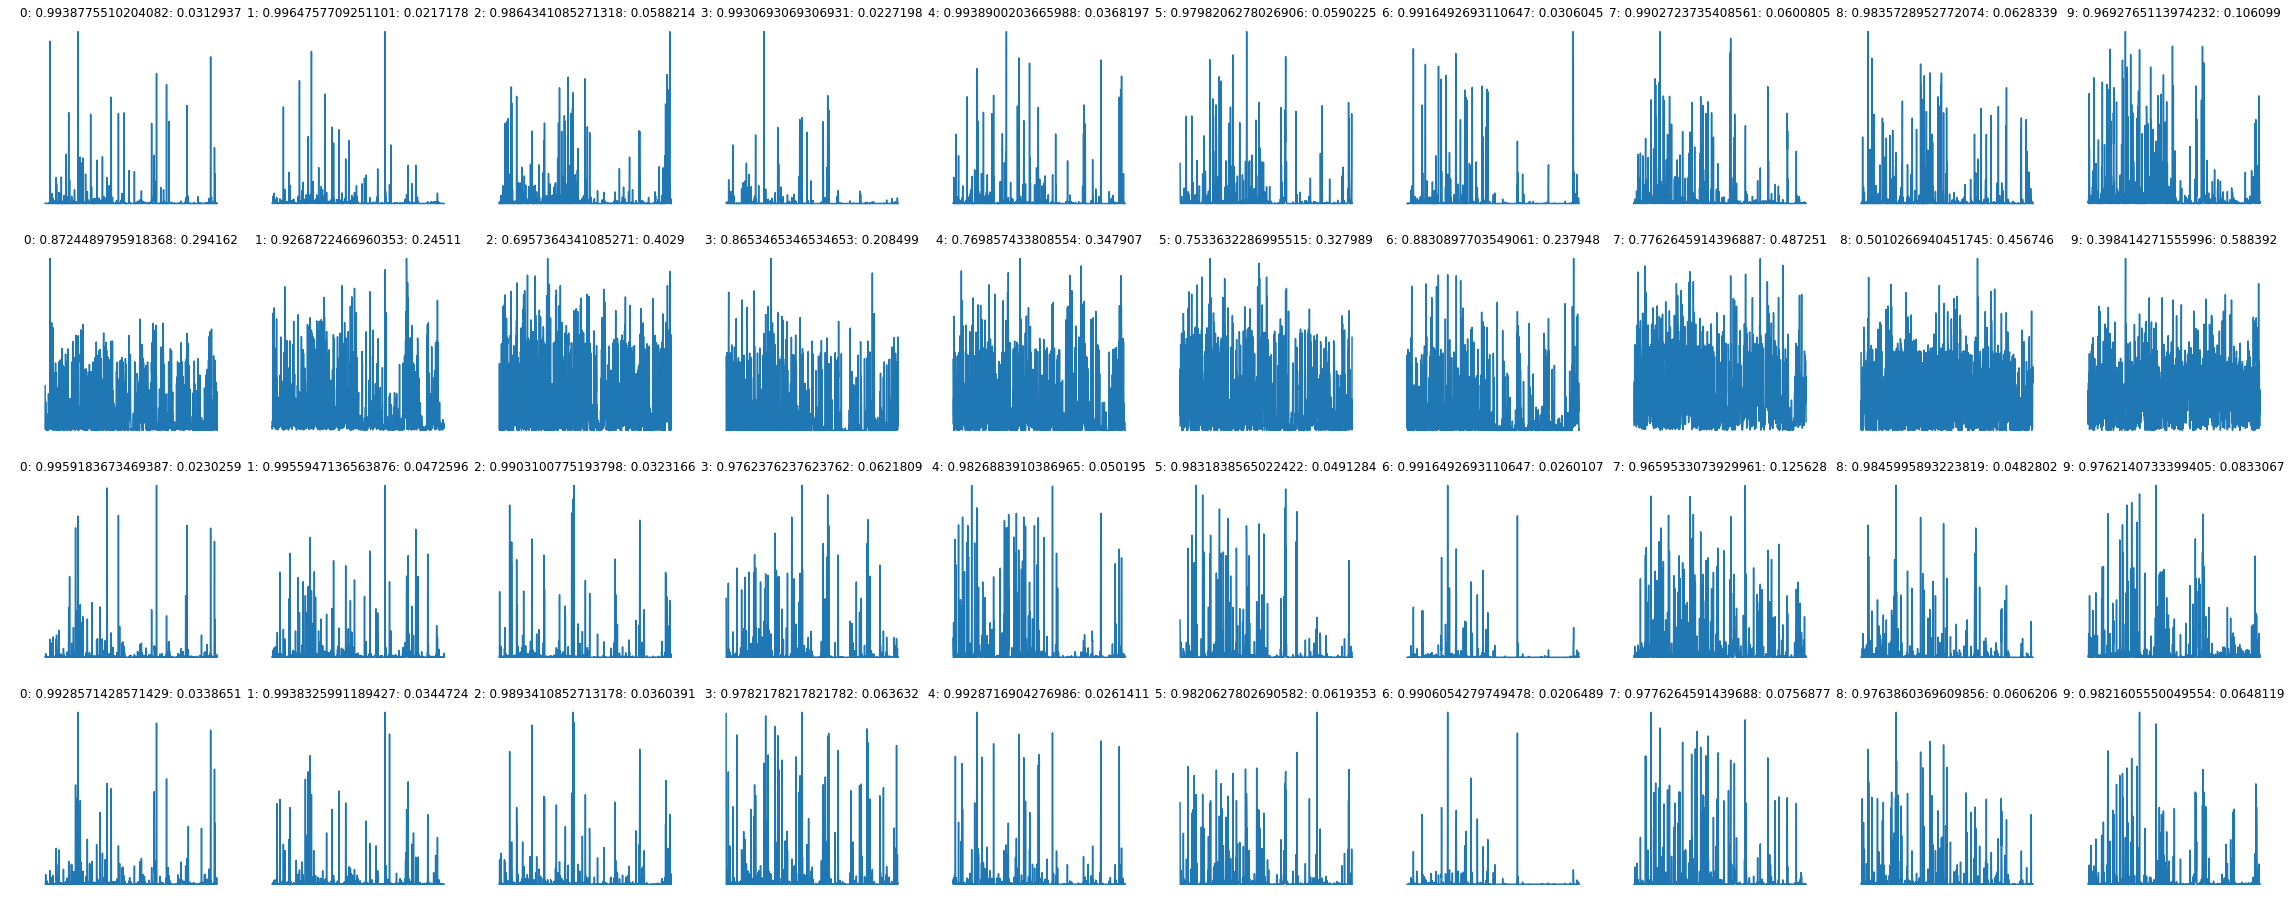

In [81]:
nrows = 4
ncols = 10
plt.rcParams['figure.figsize'] = (12.0,12.0)
plt.figure(figsize=(4*ncols, 4*nrows))

count = 1
for i in range(4):
    images_target = result_info[str(i+1)]
    for j in range(10):
        title_tmp = str(j)+': ' + str(images_target[j][1]) + ': ' + str(images_target[j][2].mean())
        
        plt.subplot(nrows, ncols, count)
        plt.plot(images_target[j][2])
        plt.title(title_tmp)
        plt.axis('off')
        count += 1
plt.show()
